Performing inference using native SDXL

WARNING [2024-07-04 15:00:24] /data/home/wangyi/workspace/diffusers/src/onediff/infer_compiler/backends/oneflow/transform/manager.py:123 - Pydantic version 1.10.13 is too low, please upgrade to 2.5.2 or higher.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

W20240704 15:00:46.865669 3431983 cuda_stream.cpp:49] Runtime version 12.1 of cuBLAS incompatible with compiletime version 12.2.


  0%|          | 0/30 [00:00<?, ?it/s]

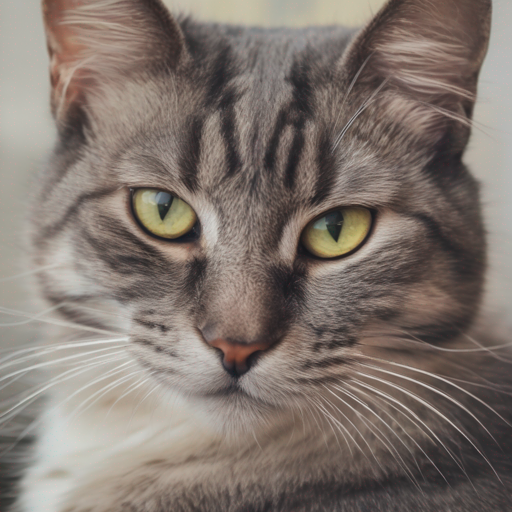

In [1]:
import torch
from diffusers import DiffusionPipeline
from onediffx import compile_pipe
from onediffx.lora import load_and_fuse_lora, set_and_fuse_adapters, delete_adapters, unfuse_lora, load_lora_and_optionally_fuse

MODEL_ID = "/share_nfs/hf_models/stable-diffusion-xl-base-1.0"
pipe = DiffusionPipeline.from_pretrained(MODEL_ID, variant="fp16", torch_dtype=torch.float16).to("cuda")
pipe = compile_pipe(pipe)

images_fusion = pipe(
    "a cat",
    height=1024,
    width=1024,
    generator=torch.manual_seed(0),
    num_inference_steps=30,
).images[0]
display(images_fusion.resize((512, 512)))

Using `load_lora_and_optionally_fuse` to load LoRA without fusing by setting `fuse=False`, the generated images are the same as native SDXL. At this point, LoRA has been loaded into the pipeline but is not participating in the computation

  0%|          | 0/30 [00:00<?, ?it/s]

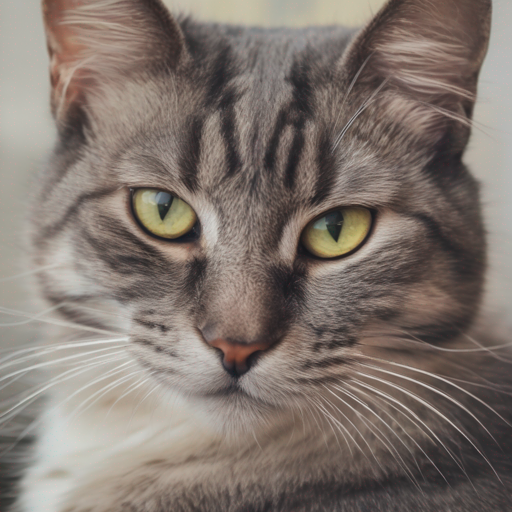

In [2]:
LORA_MODEL_ID = "Norod78/SDXL-YarnArtStyle-LoRA"
LORA_FILENAME = "SDXL_Yarn_Art_Style.safetensors"
# when setting fuse=False, the LoRA will not affect the generated images, but loaded into the corresponding blocks
load_lora_and_optionally_fuse(pipe, LORA_MODEL_ID, weight_name=LORA_FILENAME, adapter_name="SDXL_Yarn_Art_Style", fuse=False)
images_fusion = pipe(
    "a cat",
    height=1024,
    width=1024,
    generator=torch.manual_seed(0),
    num_inference_steps=30,
).images[0]
display(images_fusion.resize((512, 512)))

Using `set_and_fuse_adapters` to activate the corresponding LoRA and fuse it into the model for better inference speed, you can see that the generated images now contain the information from LoRA.

  0%|          | 0/30 [00:00<?, ?it/s]

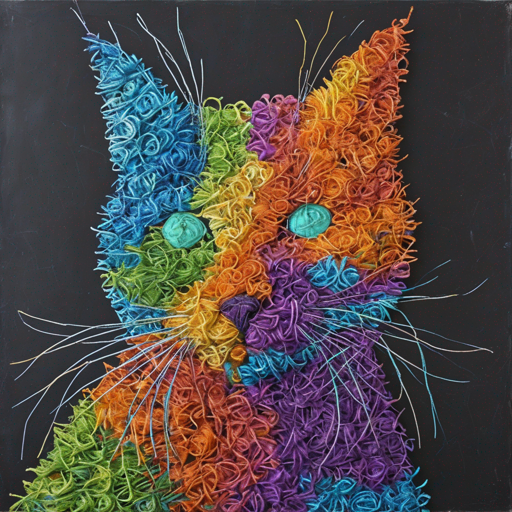

In [3]:
set_and_fuse_adapters(pipe, ['SDXL_Yarn_Art_Style'], 1.0)
images_fusion = pipe(
    "a cat",
    height=1024,
    width=1024,
    generator=torch.manual_seed(0),
    num_inference_steps=30,
).images[0]
display(images_fusion.resize((512, 512)))

Use `load_and_fuse_lora` to load a new watercolor LoRA. You can see that the generated images now exhibit both the SDXL_Yarn_Art_Style and watercolor styles. If you need to load different LoRAs sequentially, we recommend using `load_lora_and_optionally_fuse` and set `fuse=False` to load the LoRAs (without fusing), and then use 'set_adapters' to fuse them before generating images. Or invoke `unfuse_lora` before invoking `load_and_fuse_lora`

  0%|          | 0/30 [00:00<?, ?it/s]

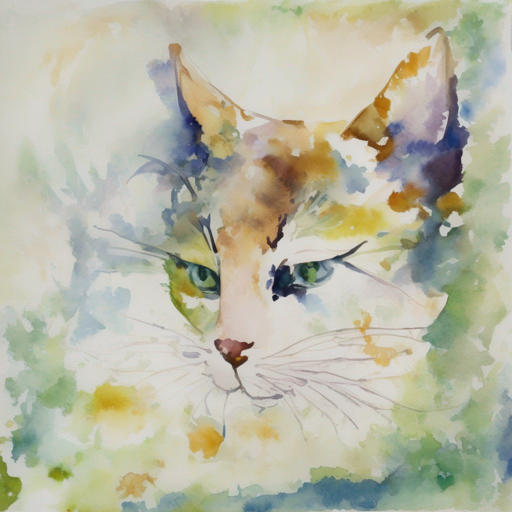

In [4]:
unfuse_lora(pipe)

LORA_MODEL_ID = "ostris/watercolor_style_lora_sdxl"
LORA_FILENAME = "watercolor_v1_sdxl.safetensors"
load_and_fuse_lora(pipe, LORA_MODEL_ID, weight_name=LORA_FILENAME, lora_scale=1.0, adapter_name="watercolor")
images_fusion = pipe(
    "a cat",
    height=1024,
    width=1024,
    generator=torch.manual_seed(0),
    num_inference_steps=30,
).images[0]
display(images_fusion.resize((512, 512)))

  0%|          | 0/30 [00:00<?, ?it/s]

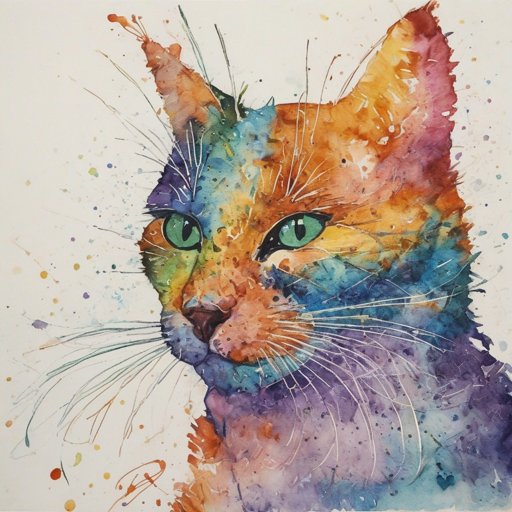

In [5]:
set_and_fuse_adapters(pipe, ['watercolor', 'SDXL_Yarn_Art_Style'], [0.4, 1.0])
images_fusion = pipe(
    "a cat",
    height=1024,
    width=1024,
    generator=torch.manual_seed(0),
    num_inference_steps=30,
).images[0]
display(images_fusion.resize((512, 512)))

Use `delete_adapters` to remove specific adapters or all adapters.

  0%|          | 0/30 [00:00<?, ?it/s]

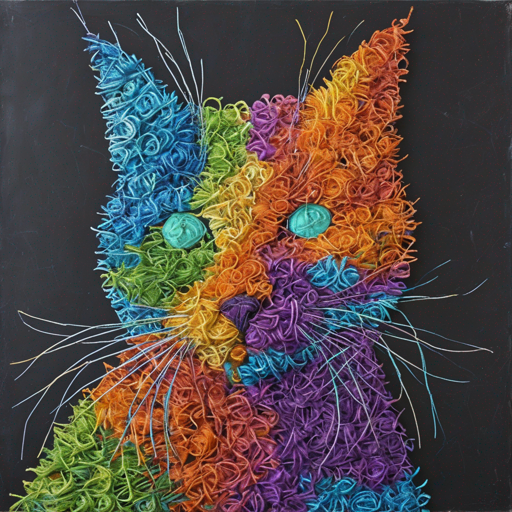

In [6]:
delete_adapters(pipe, ['watercolor'])
images_fusion = pipe(
    "a cat",
    height=1024,
    width=1024,
    generator=torch.manual_seed(0),
    num_inference_steps=30,
).images[0]
display(images_fusion.resize((512, 512)))

If `delete_adapters` is called without specifying `adapter_names`, then all adapters will be deleted

  0%|          | 0/30 [00:00<?, ?it/s]

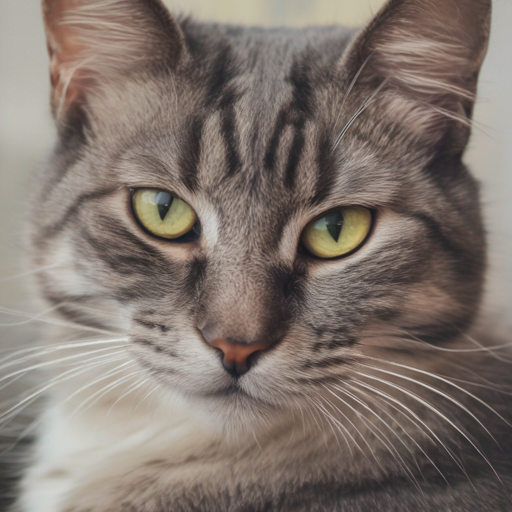

In [7]:
# will delete all adapters of pipeline
delete_adapters(pipe)
images_fusion = pipe(
    "a cat",
    height=1024,
    width=1024,
    generator=torch.manual_seed(0),
    num_inference_steps=30,
).images[0]
display(images_fusion.resize((512, 512)))